In [1]:
import sys
from metadensity.metadensity import *
from metadensity.plotd import *
import pandas as pd
import matplotlib.pyplot as plt


Using:  /home/hsher/gencode_coords/gencode.v33.transcript.gff3


# Load encode metadata
I have precompiled list of uID and the .bam, .bigWig files in the following dataframe.

In [2]:
encode4 = pd.read_csv('/home/hsher/projects/ClipNet/archishma/ENCODE4_1214.csv')

`minus_0` is the bigWig file for `minus` strand for replicate `0`. The files are in `/home/hsher/seqdata/eclip_raw`. You don't need to specify all of them. The eCLIP object will take care of them.

# load RBPs into eCLIP object

I build an eCLIP object that will connect all .bam, .bigWig and .bed (for IDR peaks, individual peaks) together. All you need to do is point a row of the previous dataframe, and use `RBP_centric_approach()` to compute the regions for metagene, and find positive (transcripts with IDR) and negative (transcript w/o any peaks) examples. Building the object will take a while (~1 min) since a lot of I/O.

In [3]:
encode4.loc[encode4['RBP']=='SF3A1']

,Unnamed: 0,uid,Batch,RBP,prefix,bam_0,bam_1,bam_control,plus_0,plus_1,plus_control,minus_0,minus_1,minus_control,bed_0,bed_1,idr,Cell Line
29,29,4048,batch12,SF3A1,encode4_batch12.4048,/projects/ps-yeolab5/encore/processing/encore_...,/projects/ps-yeolab5/encore/processing/encore_...,/projects/ps-yeolab5/encore/processing/encore_...,/projects/ps-yeolab5/encore/processing/encore_...,/projects/ps-yeolab5/encore/processing/encore_...,/projects/ps-yeolab5/encore/processing/encore_...,/projects/ps-yeolab5/encore/processing/encore_...,/projects/ps-yeolab5/encore/processing/encore_...,/projects/ps-yeolab5/encore/processing/encore_...,/projects/ps-yeolab5/encore/processing/encore_...,/projects/ps-yeolab5/encore/processing/encore_...,/projects/ps-yeolab5/encore/processing/encore_...,K562
48,48,4117,batch17,SF3A1,encode4_batch17.4117,/projects/ps-yeolab5/encore/processing/encore_...,/projects/ps-yeolab5/encore/processing/encore_...,/projects/ps-yeolab5/encore/processing/encore_...,/projects/ps-yeolab5/encore/processing/encore_...,/projects/ps-yeolab5/encore/processing/encore_...,/projects/ps-yeolab5/encore/processing/encore_...,/projects/ps-yeolab5/encore/processing/encore_...,/projects/ps-yeolab5/encore/processing/encore_...,/projects/ps-yeolab5/encore/processing/encore_...,/projects/ps-yeolab5/encore/processing/encore_...,/projects/ps-yeolab5/encore/processing/encore_...,/projects/ps-yeolab5/encore/processing/encore_...,HepG2


In [4]:
SF3A1_K562 = eCLIP.from_series(encode4.loc[encode4['RBP']=='SF3A1'].iloc[0], single_end = True)
SF3A1_HepG2= eCLIP.from_series(encode4.loc[encode4['RBP']=='SF3A1'].iloc[1], single_end = True)

# Build Metagene Density

Object `Metatruncation` and `Metadensity` takes three things:
1. an experiment object `eCLIP` or `STAMP`.
2. a set of transcript pyBedTools that you want to plot on
3. name of the object

Options include:
1. `sample_no=` allows you to decide how many transcript you want to build the density. It will take longer. By default, `sample_no=200`. So in transcript if you give more than 200 transcripts, only 200 will be used
2. `metagene` allows you to use pre-built metagene. This feature is more useful when you want to compare the same set of RNA over many RBPs.
3. `background_method` handles how you want to deal with IP v.s. Input
4. `normalize` handles how you want to normalize values within a transcript.

## Difference between truncation and density

`Metadensity` represents read coverage. `Metatruncation` represents the 5' end of read 2 for `eCLIP`; edit sites for `STAMP`.

In [5]:
def build_idr_metadensity(eCLIP):
    ''' build metadensity object for eCLIP and its idr peak containing transcript'''
    idr_transcripts = transcript.intersect(eCLIP.idr, u = True, s = True).saveas()
    m = Metadensity(eCLIP, eCLIP.name+'_idr',background_method = 'subtract', normalize = True, transcripts = idr_transcripts)
    m.get_density_array()
    return m
def build_idr_metatruncate(eCLIP):
    ''' build metadensity object for eCLIP and its idr peak containing transcript'''
    idr_transcripts = transcript.intersect(eCLIP.idr, u = True, s = True).saveas()
    m = Metatruncate(eCLIP, eCLIP.name+'_idr',background_method = 'subtract', normalize = True, transcripts = idr_transcripts)
    m.get_density_array(use_truncation = True)
    return m

In [6]:
metas = [] # concatentae all metagene objet into this list
for e in [SF3A1_HepG2, SF3A1_K562]:
    metas.append(build_idr_metatruncate(e))

Using: /home/hsher/miniconda3/envs/metadensity/lib/python3.7/site-packages/metadensity-0.0.1-py3.7.egg/metadensity/data/hg38/gencode
Done building metagene
Using: /home/hsher/miniconda3/envs/metadensity/lib/python3.7/site-packages/metadensity-0.0.1-py3.7.egg/metadensity/data/hg38/gencode
Done building metagene


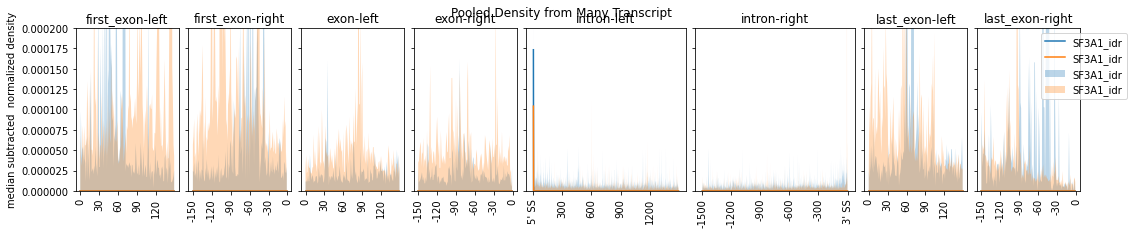

In [11]:
f = plot_mean_density(metas, stat = 'median', features_to_show = ['first_exon','exon','intron', 'last_exon'], ymax = 0.0002)

/home/hsher/miniconda3/envs/metadensity/lib/python3.7/site-packages/metadensity-0.0.1-py3.7.egg/metadensity/plotd.py:145: RuntimeWarning: Mean of empty slice
  density_concat = np.nanmean(np.stack([den_arr[feat,align, r] for r in m.eCLIP.rep_keys]), axis = 0)


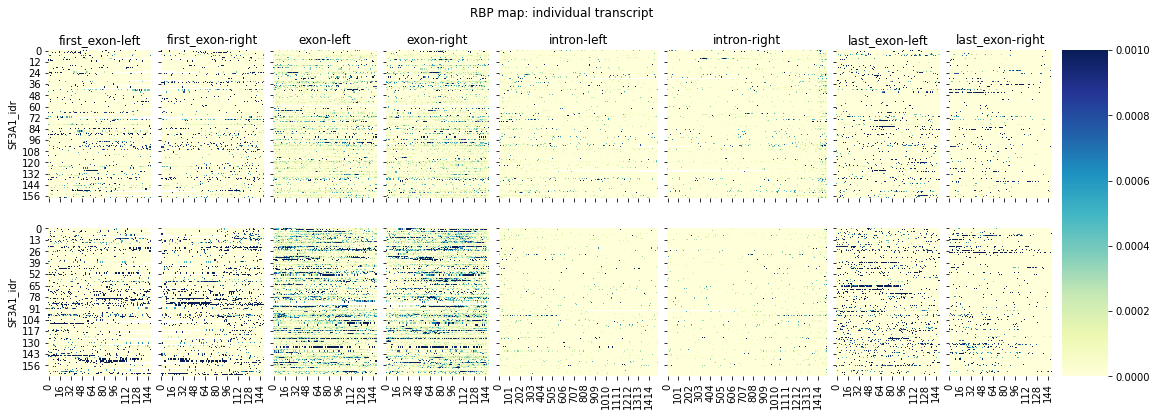

In [8]:
f = plot_rbp_map(metas, features_to_show = ['first_exon','exon','intron', 'last_exon'])

In [9]:
metas_read = [] # concatentae all metagene objet into this list
for e in [SF3A1_HepG2, SF3A1_K562]:
    metas_read.append(build_idr_metadensity(e))

Using: /home/hsher/miniconda3/envs/metadensity/lib/python3.7/site-packages/metadensity-0.0.1-py3.7.egg/metadensity/data/hg38/gencode
Done building metagene
Using: /home/hsher/miniconda3/envs/metadensity/lib/python3.7/site-packages/metadensity-0.0.1-py3.7.egg/metadensity/data/hg38/gencode
Done building metagene


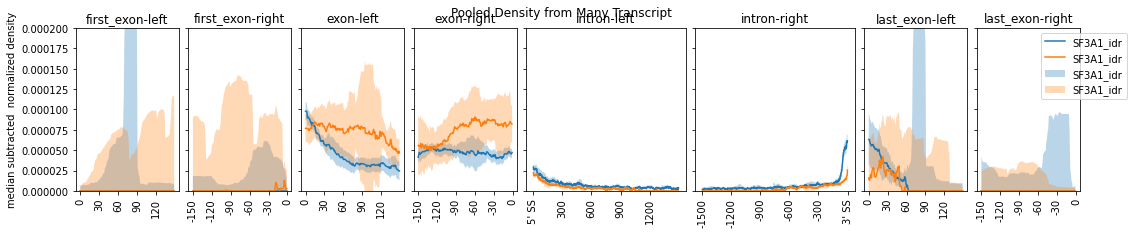

In [10]:
# observe the difference with using reads instead of read starts
f = plot_mean_density(metas_read, stat = 'median', features_to_show = ['first_exon','exon','intron', 'last_exon'], ymax = 0.0002)

/home/hsher/miniconda3/envs/metadensity/lib/python3.7/site-packages/metadensity-0.0.1-py3.7.egg/metadensity/plotd.py:145: RuntimeWarning: Mean of empty slice
  density_concat = np.nanmean(np.stack([den_arr[feat,align, r] for r in m.eCLIP.rep_keys]), axis = 0)


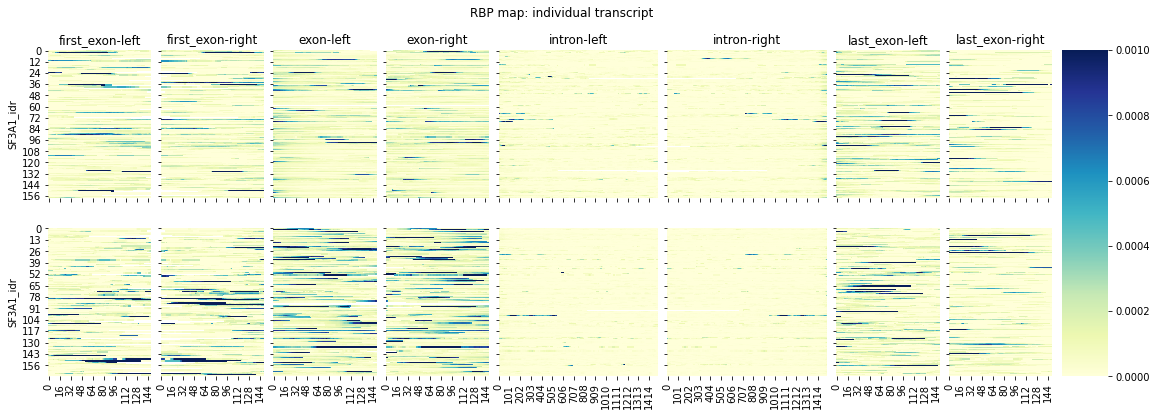

In [12]:
f = plot_rbp_map(metas_read, features_to_show = ['first_exon','exon','intron', 'last_exon'])